# Thesis Simulations
This notebook contains the code that creates all figures for the simulation and visualizations of the thesis.

In [1]:
from datasets import Dataset
from cblearn.datasets import make_all_triplets
from estimators import LandmarkTangles
from plotting import AltairPlotter, ThesisPlotter, save_all, CB_COLOR_CYCLE, LINE_STYLES, MARKER_SIZES
from altair_saver import save
from sklearn.cluster import KMeans
from questionnaire import Questionnaire
from thesis import ClusteringEvaluationSuite, DataCache, eval_hierarchical
from estimators import SoeKmeans, LandmarkTangles
from triplets import subsample_triplets, unify_triplet_order, triplets_to_majority_neighbour_cuts
from cblearn.embedding import SOE
from pathlib import Path
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tueplots import bundles
from data_generation import generate_gmm_data_fixed_means
import math
from hierarchies import BinaryHierarchyTree
import matplotlib as mpl
mpl.rcParams.update(bundles.icml2022())
mpl.rcParams.update({"font.size": 80, "axes.labelsize": 15, "xtick.labelsize": 14, "ytick.labelsize": 14, "legend.fontsize": 10})

RESULTS_FOLDER = 'results'
INITIAL_SEED = 1
N_RUNS = 50
USED_EMBEDDERS = ["SOE", "TSTE"]
METHODS_PLOTTED = ["L-Tangles", "ComparisonHC", "M-Tangles", "SOE", "TSTE", "L-Tangles H.", "ComparisonHC H.", "M-Tangles H.", "SOE-AL H."]
STYLE_DICT = dict(zip(METHODS_PLOTTED, zip(LINE_STYLES, CB_COLOR_CYCLE, MARKER_SIZES)))

verbose=True
ap = AltairPlotter()
tp = ThesisPlotter(Path(RESULTS_FOLDER), set(METHODS_PLOTTED), STYLE_DICT)
force_rerun = False
# %load_ext autoreload
# %autoreload 2
def print_(*args, **kwargs):
    if verbose:
        print(*args, **kwargs)

small_agreement = 7
small_radius = 1/2

/opt/homebrew/Caskroom/mambaforge/base/envs/tangles-thesis/lib/python3.9/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/tangles-thesis/lib/python3.9/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/tangles-thesis/lib/python3.9/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
def add_density(df, max_triplets):
    df['density'] = df['num_triplets'] / max_triplets
    return df

## Majority tangles

### Majority cuts appearance [Fig. TODO]
This figure shows how the majority cuts look like on a simple dataset.

#triplets = 100
#triplets = 500
#triplets = 1000
#triplets = 5000
#triplets = 10000
#triplets = 20000
#triplets = 50000
#triplets = 106200


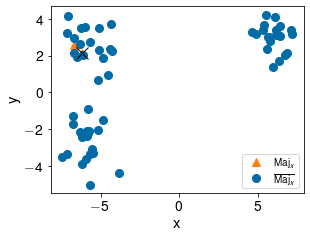

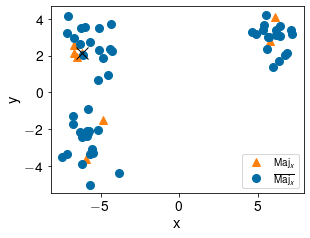

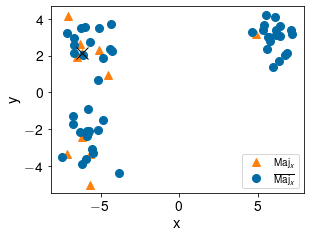

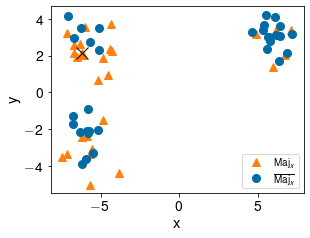

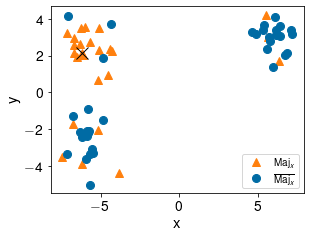

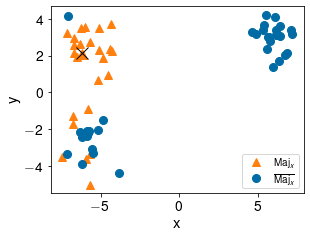

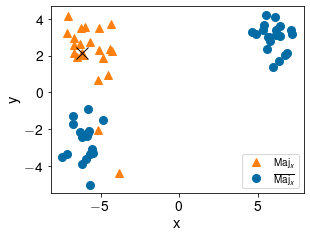

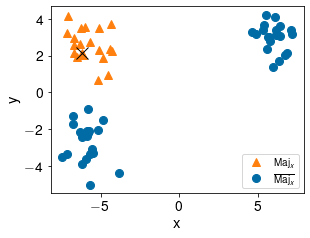

In [3]:
num_triplets = [100, 500, 1000, 5000, 10000, 20000, 50000, 106200]

data = Dataset.get(Dataset.GAUSS_SMALL, INITIAL_SEED)
for n in num_triplets:
    print_(f"#triplets = {n}")
    triplets, responses = subsample_triplets(data.xs, n, no_redraw=True)
    unified_triplets = unify_triplet_order(triplets, responses)
    cuts = triplets_to_majority_neighbour_cuts(
        unified_triplets, radius=1 / 2)

    p = 8
    tp.assignments_different_symbols(data.xs, cuts[p, :], reverse=True)
    plt.legend([r"$\mathrm{Maj}_x$", r"$\overline{\mathrm{Maj}_x}$" ])
    #plt.title(f"Majority cuts, r=0.5, \#triplets={n}")
    plt.plot(data.xs[p, 0], data.xs[p, 1], "kx", markersize=12)
    tp.save(f"majority-cut-{p}-n_triplets-{n}")

### Adding noise (small) [Fig. TODO]
This figure shows how adding noise to majority cuts changes their performance.

In [4]:
def adding_noise_num_triplets(dataset, num_triplets, noises):
    seed = INITIAL_SEED
    for noise in noises:
        for num in num_triplets:
            print_(f"noise: {noise}, num_triplets: {num}")
            for n in range(N_RUNS):
                seed += 1
                data = Dataset.get(dataset, seed)
                num_datapoints = data.xs.shape[0]
                t, r = subsample_triplets(data.xs, num, noise=noise, no_redraw=True)
                yield t, r, data.ys, {'num_triplets': num, 'run': n, 'noise': noise}

In [5]:
exp_name = "adding_noise_small_majority"
noises = np.arange(0, 0.51, 0.05)
#densities = [0.01]
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load():
    eval_suite = ClusteringEvaluationSuite(small_agreement, 2, KMeans(3), seed=0, methods_to_include=["M-Tangles", "ComparisonHC"] + USED_EMBEDDERS, radius=small_radius)
    df = eval_suite.score_all(adding_noise_num_triplets(Dataset.GAUSS_SMALL, num_triplets=[20000], noises=noises))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/adding_noise_small_majority.csv...


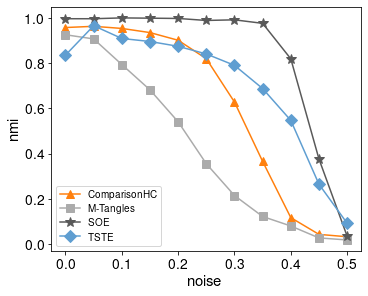

In [6]:
tp.line(cache.data, x="noise", y="nmi")
tp.save(exp_name)

### Reducing number of triplets [Fig. TODO]
This figure shows how majority cuts behave with increasing/decreasing number of triplets.

In [7]:
exp_name = "reducing_triplets_small"
num_triplets = [200, 500, 1000, 5000, 10000, 20000, 50000, 106200]
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load():
    dfs = []
    eval_suite = ClusteringEvaluationSuite(small_agreement, 2, KMeans(3), seed=0, radius=small_radius, methods_to_include=["M-Tangles", "ComparisonHC", "L-Tangles"] + USED_EMBEDDERS, imputation="1-NN")
    df = eval_suite.score_all(adding_noise_num_triplets(Dataset.GAUSS_SMALL, num_triplets=num_triplets, noises=[0]))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/reducing_triplets_small.csv...


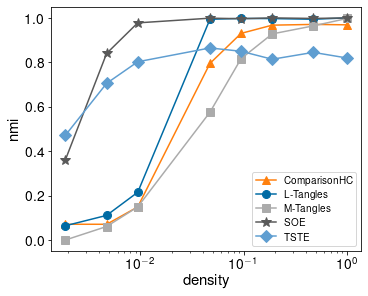

In [8]:
tp.line(add_density(cache.data, 106200), x="density", y="nmi")
plt.xscale("log")
tp.save(exp_name)

In [9]:
exp_name = "imputing_missing_small"
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load():
    all_dfs = []
    for imp_method in ["random", "1-NN", "5-NN", "mean"]:
        eval_suite = ClusteringEvaluationSuite(small_agreement, 2, KMeans(3), seed=0, methods_to_include=["L-Tangles"], imputation=imp_method)
        df = eval_suite.score_all(adding_noise_num_triplets(Dataset.GAUSS_SMALL, num_triplets=num_triplets, noises=[0]))
        df = df.assign(method=imp_method)
        all_dfs.append(df)
    total_df = pd.DataFrame(pd.concat(all_dfs))
    cache.save(total_df) 


Previous experiment result found.
Loading data from cache at results/imputing_missing_small.csv...


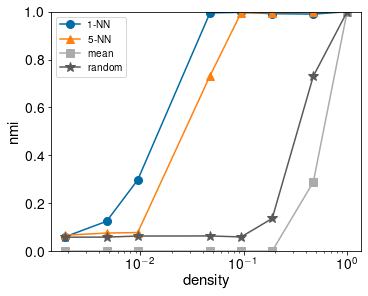

In [10]:
tp.line(add_density(cache.data, 106200), x="density", y="nmi", methods_to_use=set(["random", "1-NN", "5-NN", "mean"]), use_style_dict=False)
plt.ylim(0, 1.0)
plt.xscale("log")
tp.save(exp_name)

## Landmark tangles

### All points gaussian (small) [Fig. TODO]
This figure shows the look of the general clustering and the dataset.

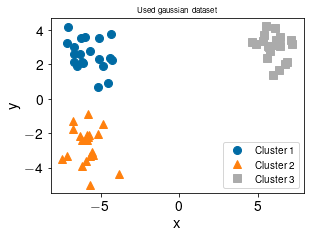

In [11]:
data = Dataset.get(Dataset.GAUSS_SMALL, INITIAL_SEED)
t,r = make_all_triplets(data.xs, "list-boolean")
tangles = LandmarkTangles(agreement=5, verbose=False)
ys = tangles.fit_predict(t, r)
tp.assignments_different_symbols(data.xs, ys)
plt.legend()
plt.title("Used gaussian dataset")
save_all(RESULTS_FOLDER, "gaussian_small_tangles_clustering")

### Weird geometry

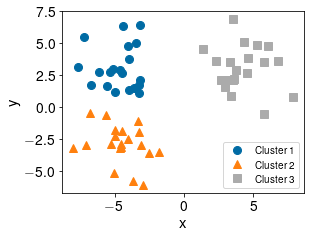

In [12]:
means = np.array([[-4, 3], [-4, -3], [4, 3]])
data = generate_gmm_data_fixed_means(20, means, std=1.5, seed=2)
tp.assignments_different_symbols(data.xs, data.ys)
plt.legend();

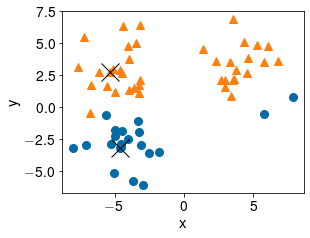

In [13]:
dists = pairwise_distances(data.xs)
def make_cut(a,b, dists):
    return dists[a, :] < dists[b, :]
a = 10
b = 30
cut = make_cut(a, b, dists)
tp.assignments_different_symbols(data.xs, cut, markersize=8)
plt.plot(data.xs[a, 0], data.xs[a, 1], "kx", markersize=18)
plt.plot(data.xs[b, 0], data.xs[b, 1], "kx", markersize=18)
save_all(RESULTS_FOLDER, "weird-geometry-cuts")

In [14]:
soe_kmeans = SoeKmeans(2, 3, seed=0)
tangles = LandmarkTangles(8, verbose=False)
runs = 50

if force_rerun:
    soe_score = 0
    tangles_score = 0
    for i in range(runs):
        means = np.array([[-4, 3], [-4, -3], [4, 0]])
        data = generate_gmm_data_fixed_means(20, means, std=1.5, seed=2)
        t,r = Questionnaire.from_metric(data.xs, density=0.05, verbose=0, noise=0.1, flip_noise=True).to_bool_array()
        soe_score += soe_kmeans.score(t, r, data.ys)
        tangles_score += tangles.score(t, r, data.ys)
    print(f"Weird geometry:\n\tSOE: {soe_score/runs}\n\tTangles: {tangles_score/runs}")

    soe_score = 0
    tangles_score = 0
    for i in range(runs):
        means = np.array([[-4, 3], [-4, -3], [4, 3]])
        data = generate_gmm_data_fixed_means(20, means, std=1.5, seed=2)
        t,r = Questionnaire.from_metric(data.xs, density=0.05, verbose=0, noise=0.1, flip_noise=True).to_bool_array()
        soe_score += soe_kmeans.score(t, r, data.ys)
        tangles_score += tangles.score(t, r, data.ys)
    print(f"Nice geometry:\n\tSOE: {soe_score/runs}\n\tTangles: {tangles_score/runs}")

### Lowering density (small)
The figure shows how the landmark-tangles perform with decreasing number of landmark-questions.

In [15]:
def lowering_density_adding_noise_gen(dataset, densities, noises):
    seed = INITIAL_SEED
    for density in densities:
        for noise in noises:
            print(f"density: {density}, noise: {noise}")
            for n in range(N_RUNS):
                seed += 1
                data = Dataset.get(dataset, seed)
                t, r = Questionnaire.from_metric(data.xs, density=density, noise=noise, seed=seed, verbose=False, flip_noise=True).to_bool_array()
                yield t, r, data.ys, {'density': density, 'run': n, 'noise': noise}

In [16]:
exp_name = "lower_density_small"
densities = np.logspace(0, -4, 20)
#densities = [0.01]
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load():
    eval_suite = ClusteringEvaluationSuite(7, 2, KMeans(3), seed=0, methods_to_include=["L-Tangles", "M-Tangles", "ComparisonHC"] + USED_EMBEDDERS)
    df = eval_suite.score_all(lowering_density_adding_noise_gen(Dataset.GAUSS_SMALL, densities, noises=[0.0]))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/lower_density_small.csv...


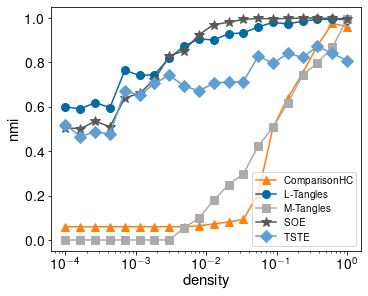

In [17]:
tp.line(cache.data, "density", "nmi")
plt.xscale("log")
tp.save(exp_name)

### Lowering density (large) [Fig. TODO]
Similar to small, just bigger.

In [18]:
exp_name = "lower_density_large"
densities = np.logspace(-3, -6, 15).tolist()
#densities = [0.0001, 0.00008, 0.00005]
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load():
    eval_suite = ClusteringEvaluationSuite(70, 2, KMeans(3), seed=0, methods_to_include=["L-Tangles", "M-Tangles"] + USED_EMBEDDERS)
    df = eval_suite.score_all(lowering_density_adding_noise_gen(Dataset.GAUSS_LARGE, densities, noises=[0.0]))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/lower_density_large.csv...


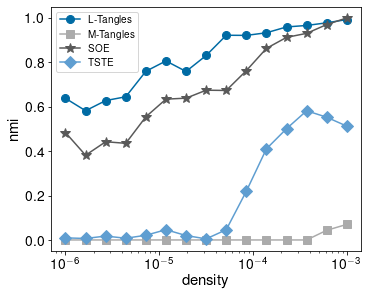

In [19]:
tp.line(cache.data, "density", "nmi")
plt.xscale("log")
tp.save(exp_name)

### Adding noise and lowering density [Fig. TODO]
Shows how landmark tangles behaves in comparison to SOE (with randomly drawn triplets
and same triplets) when lowering both the density and adding noise.

In [20]:
exp_name = "lower_density_add_noise_small"
noises = np.arange(0, 0.41, 0.02)
densities = np.logspace(0, -4, 20)
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load() :
    eval_suite = ClusteringEvaluationSuite(7, 2, KMeans(3), seed=0, methods_to_include=["L-Tangles", "SOE"] )
    df = eval_suite.score_all(lowering_density_adding_noise_gen(Dataset.GAUSS_SMALL, densities, noises))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/lower_density_add_noise_small.csv...


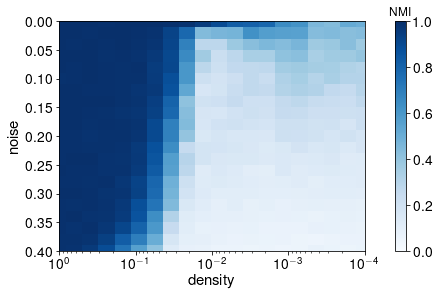

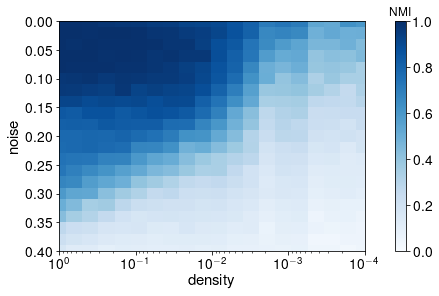

In [21]:
tp.heatmap(cache.data, "density", "noise", "nmi", "SOE", "NMI")
save_all(RESULTS_FOLDER, "gaussian_small_lower_density_noise_heatmap_soe")
tp.heatmap(cache.data, "density", "noise", "nmi", "L-Tangles", "NMI")
save_all(RESULTS_FOLDER, "gaussian_small_lower_density_noise_heatmap_l_tangles")

### Adding noise (small) [Fig. TODO]
Shows how landmark tangles behaves when adding noise to the triplets

In [22]:
exp_name = "adding_noise_small"
noises = np.arange(0, 0.51, 0.05)
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load() :
    eval_suite = ClusteringEvaluationSuite(7, 2, KMeans(3), seed=0, methods_to_include=["L-Tangles", "M-Tangles", "ComparisonHC"] + USED_EMBEDDERS)
    df = eval_suite.score_all(lowering_density_adding_noise_gen(Dataset.GAUSS_SMALL, densities=[1.0], noises=noises))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/adding_noise_small.csv...


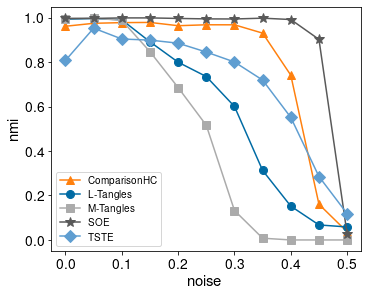

In [23]:
tp.line(cache.data, "noise", "nmi")
tp.save(exp_name)

## Tangles and Hierarchies

### Add Triplet noise (Hierarchical) [Fig. TODO]

In [24]:
def df_add_triplet_noise(density):
    df = pd.DataFrame(columns=["Triplet Noise", "L-Tangles", "SOE", "M-Tangles", "ComparisonHC", "L-Tangles H.", "ComparisonHC H.", "M-Tangles H.", "SOE-AL H."])
    for tn in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        l, s, m, c, hl, hc, hm, hs = eval_hierarchical(noise=tn, n_runs=N_RUNS, density=density)
        df = df.append(pd.Series([tn, l, s, m, c, hl, hc, hm, hs], index=df.columns), ignore_index=True)
    return df.melt(id_vars=["Triplet Noise"], var_name="method", value_vars=list(df.columns[1:]), value_name="NMI/AARI")
def hierarchical_line_plots(cache, x_var, save_name, xlog = False):
    tp.line(cache.data, x_var, "NMI/AARI", methods_to_use=set(["L-Tangles", "SOE", "M-Tangles", "ComparisonHC", "TSTE"]))
    if xlog:
        plt.xscale("log")
    plt.ylabel("NMI")
    save_all(RESULTS_FOLDER, save_name)
    plt.show()
    tp.line(cache.data, x_var, "NMI/AARI", methods_to_use=set(["L-Tangles H.", "SOE-AL H.", "M-Tangles H.", "ComparisonHC H."]))
    if xlog:
        plt.xscale("log")
    plt.ylabel("AARI")
    save_all(RESULTS_FOLDER, save_name + "h")
    plt.show()

In [25]:
exp_name = "hierarchical_add_triplet_noise_01"
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load() :
    df = df_add_triplet_noise(0.1)
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/hierarchical_add_triplet_noise_01.csv...


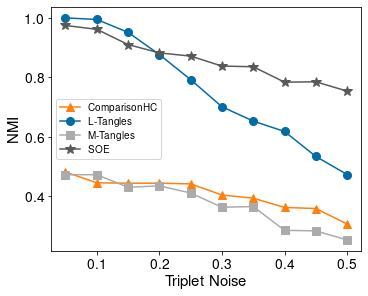

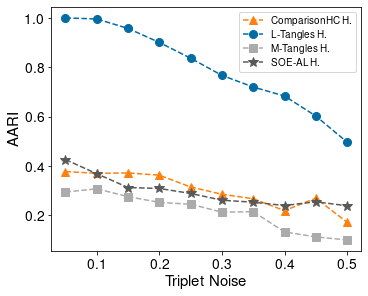

In [26]:
hierarchical_line_plots(cache, "Triplet Noise", exp_name)

In [27]:
exp_name = "hierarchical_add_triplet_noise_005"
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load() :
    df = df_add_triplet_noise(0.05)
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/hierarchical_add_triplet_noise_005.csv...


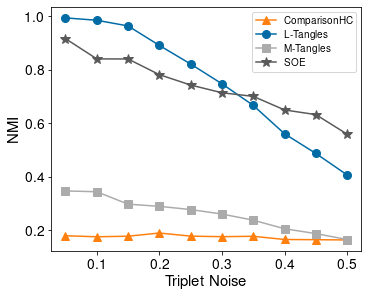

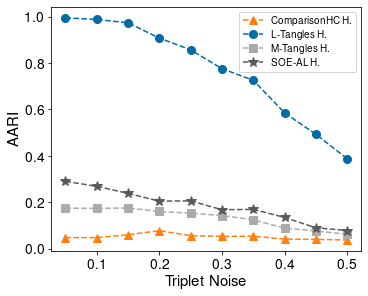

In [28]:
hierarchical_line_plots(cache, "Triplet Noise",exp_name)

### Lower density (Hierarchical) [Fig. TODO]

In [29]:
exp_name = "hierarchical_lower_density"
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load() :
    df = pd.DataFrame(columns=["Density", "L-Tangles", "SOE", "M-Tangles", "ComparisonHC", "L-Tangles H.", "ComparisonHC H.", "M-Tangles H.", "SOE-AL H."])
    for density in [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]:
        l, s, m, c, hl, hc, hm, hs = eval_hierarchical(density=density, n_runs=N_RUNS)
        df = df.append(pd.Series([density, l, s, m, c, hl, hc, hm, hs], index=df.columns), ignore_index=True)
    df = df.melt(id_vars=["Density"], var_name="method", value_vars=list(df.columns[1:]), value_name="NMI/AARI")
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/hierarchical_lower_density.csv...


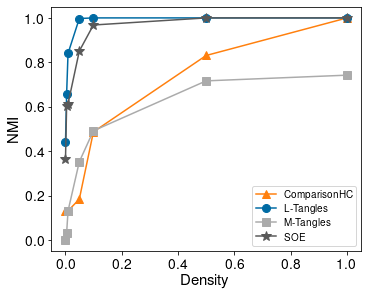

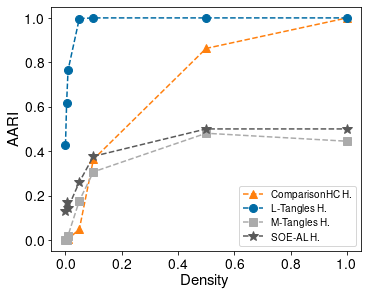

In [30]:
hierarchical_line_plots(cache, "Density", exp_name)

### Adding Hierarchy Noise [FIG. TODO]

In [31]:
exp_name = "hierarchical_add_hierarchy_noise"
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load() :
    df = pd.DataFrame(columns=["Hierarchy Noise", "L-Tangles", "SOE", "M-Tangles", "ComparisonHC", "L-Tangles H.", "ComparisonHC H.", "M-Tangles H.", "SOE-AL H."])
    for hn in [0.0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0]:
        l, s, m, c, hl, hc, hm, hs = eval_hierarchical(hier_noise=hn, n_runs=N_RUNS)
        df = df.append(pd.Series([hn, l, s, m, c, hl, hc, hm, hs], index=df.columns), ignore_index=True)
    df = df.melt(id_vars=["Hierarchy Noise"], var_name="method", value_vars=list(df.columns[1:]), value_name="NMI/AARI")
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/hierarchical_add_hierarchy_noise.csv...


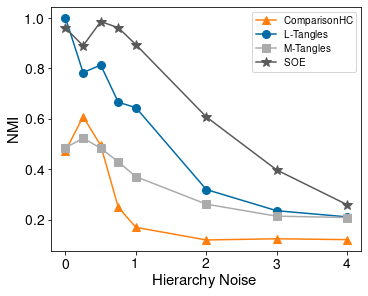

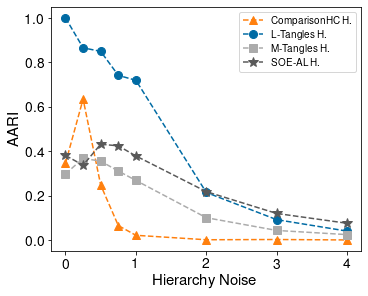

In [32]:
hierarchical_line_plots(cache, "Hierarchy Noise", exp_name)

## Problems with hierarchical noise model 
First we approximately plot the points of the hierarchical block model. 

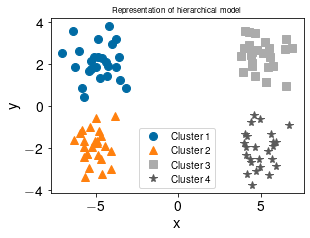

In [33]:
data = generate_gmm_data_fixed_means(n = 25, means = np.array([[-5, 2], [-5, -2], [5, 2], [5, -2]]), std=0.8, seed=0)
tp.assignments_different_symbols(data.xs, data.ys)
plt.legend()
plt.title("Representation of hierarchical model")
save_all(RESULTS_FOLDER, "hierarchical_model_repr")

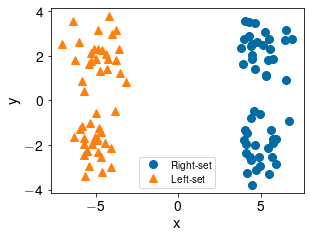

In [34]:
cut = data.ys.copy()
cut[50:] = 0
cut[:50] = 1
tp.assignments_different_symbols(data.xs, cut, markersize=8)
plt.legend(["Right-set", "Left-set"]);
save_all(RESULTS_FOLDER, "hierarchical_model_repr_cut_vert_hier_noise")

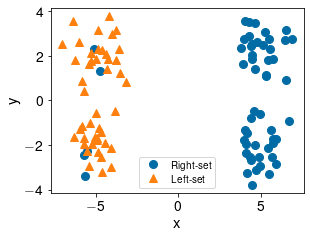

In [35]:
cut = data.ys.copy()
cut[50:] = np.logical_not(np.random.random(50) < 0.9)
cut[:50] = np.random.random(50) > 0.1
tp.assignments_different_symbols(data.xs, cut, markersize=8)
plt.legend(["Right-set", "Left-set"]);
save_all(RESULTS_FOLDER, "hierarchical_model_repr_cut_vert_triplet_noise")

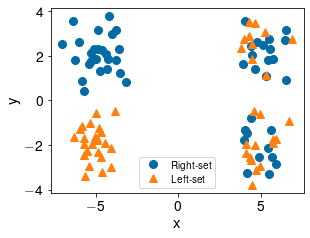

In [36]:
cut = data.ys.copy()
cut[50:] = np.random.random(50) < 0.5
cut[:50] = 1
cut[0:25] = 0
tp.assignments_different_symbols(data.xs, cut, markersize=8)
plt.legend(["Right-set", "Left-set"]);
save_all(RESULTS_FOLDER, "hierarchical_model_repr_cut_horz_hier_noise")

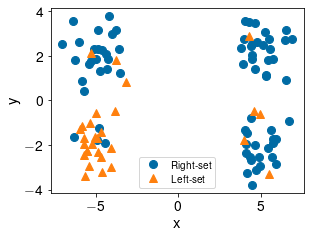

In [37]:
cut = data.ys.copy()
cut[50:] = np.logical_not(np.random.random(50) > 0.1)
cut[:25] = np.logical_not(np.random.random(25) > 0.1)
cut[25:50] = np.random.random(25) < 0.9

tp.assignments_different_symbols(data.xs, cut, markersize=8)
plt.legend(["Right-set", "Left-set"]);
save_all(RESULTS_FOLDER, "hierarchical_model_repr_cut_horz_triplet_noise")